# Introduction
This notebook compares four time-series models performance to predict total daily energy demand in Saskatchewan. These models utilized include Fb Prophet, LightGBM (Light Gradient Boosting Machine), SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors), LSTM (Long Short-Term Memory), Hybrid Prophet-LGBM, and Hybrid Prophet-LSTM. 

Each model is trained and tested using a train-test split and cross-validation. The models’ performances are evaluated using metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), Median Absolute Percentage Error (MdAPE), and R-squared and the results are stored for each fold in the cross-validation. Finally, the performance of all models are compared, conclusions are drawn based on the evaluation metrics, and potential improvements for future work are considered.

# Load Data
Forecasting daily natural gas consumption accurately is difficult because it is affected by various factors. The dataset is the historical daily natural gas demand in energy unit (TJ/d) and the weather data in Saskatchewan from November 1, 2013 to October 31, 2023. This dataset has be preprocessed and explored in the "cleaning_EDA.ipynb" notebook and is fit for model development. 

In [26]:
# Importing the necessary libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importing libraries for modules
from prophet import Prophet
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch, Objective

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle
import warnings 
warnings.filterwarnings('ignore')

In [27]:
# Import the merged dataset (Natural Gas demand and Weather factors)
merged_df = pd.read_csv('../data/merged_data.csv')
merged_df.head()

,DATE,NG_DEMAND,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,617,44.400000,80.333333,14.833333,0.0,0.140000,-2.933333,3.166667,9.206667,28.066667,40.600000
1,2013-11-02,630,34.133333,73.066667,16.293333,0.0,0.226667,-5.866667,1.706667,9.266667,8.400000,25.400000
2,2013-11-03,688,60.133333,81.600000,16.726667,0.0,5.806667,-2.166667,1.273333,4.706667,24.400000,55.000000
3,2013-11-04,815,66.466667,79.133333,23.540000,0.0,0.900000,-9.106667,-5.540000,-1.906667,31.466667,56.933333
4,2013-11-05,789,53.000000,71.666667,27.820000,0.0,0.040000,-14.966667,-9.820000,-4.633333,15.800000,21.600000


# Data Preparation for Modelling 

For this step, we are preparing the series for Cross-validation evaluation and the Train-test Split method.

- Train-test Split method: This method involves splitting the dataset into a training set and a testing set. The model is trained on the training set and then tested on the testing set to evaluate its performance.

- 
Cross-Validation: Cross-validation is a technique used to evaluate the performance of a machine learning model on unseen data. It involves dividing the available data into multiple folds or subsets, using one of these folds as a validation set, and training the model on the remaining folds

In [28]:
# Split the data into learning set from 2013-11-01 to 2022-04-31, and using 2022-05-01 to 2023-10-31 as testing set
learning_data_df = merged_df[merged_df['DATE'] < '2022-05-01'] # train/validation set
testing_data_df = merged_df[merged_df['DATE'] >= '2022-05-01'] # testing set

# Print the shape of the train-test split
print(learning_data_df.shape)
print(testing_data_df.shape)

(3103, 12)
(549, 12)


# Model Building
In this project, the recommended models to be utilized are Prophet, LightGBM, SARIMAX, LSTM, Hybrid Prophet-LGBM, and Hybrid Prophet-LSTM.

## 1. Baseline Model
In every modeling process, there needs to be a baseline model whose results can be used to assess our primary ones. In our case, we chose to use a Linear Regression model because of its simplicity and efficiency.

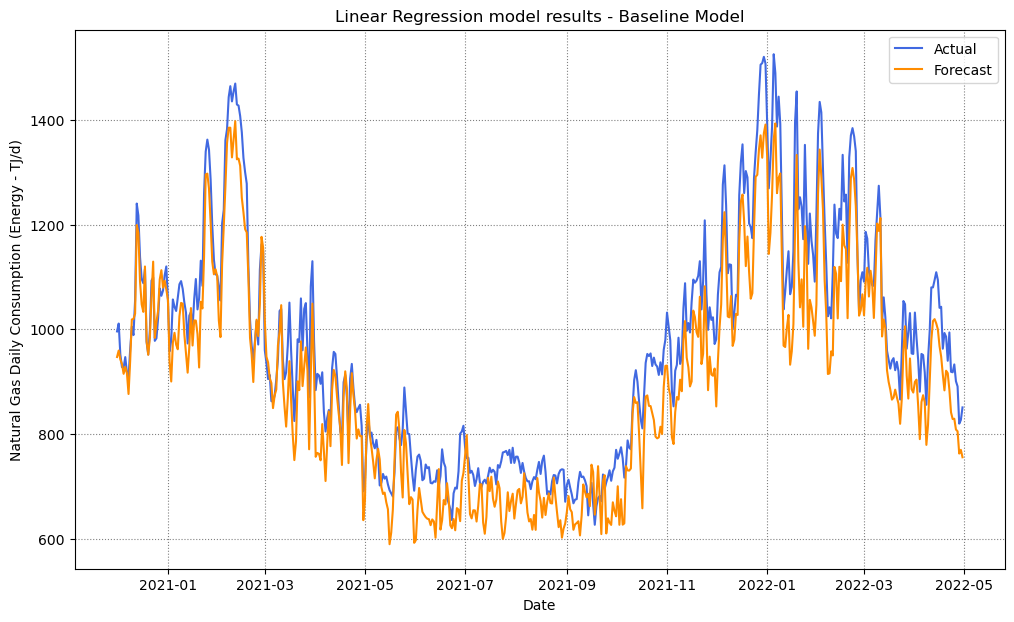

Mean Squared Error: 6656.06
Mean Absolute Error: 70.18
Root Mean Squared Error: 81.58
R-squared: 0.85
Mean Absolute Percentage Error: 7.33%
Median Absolute Percentage Error: 7.05%


In [8]:
# Split the learning dataset to training and validation sets
learning_df = learning_data_df.copy()
training_df = learning_df[learning_df['DATE'] < '2020-12-01']
validation_df = learning_df[learning_df['DATE'] >= '2020-12-01']

# Function to calculate MAPE and MdAPE
def calculate_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    return mape, mdape

# Use the train_df for training
X_train = training_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y_train = training_df['NG_DEMAND']

# Use the validation_df for testing
X_test = validation_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y_test = validation_df['NG_DEMAND']

# Create a Linear Regression object
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Make predictions on the test set
predictions = lr.predict(X_test)

# Calculate the mean squared error of the predictions
mse_bm = mean_squared_error(y_test, predictions)
mae_bm = mean_absolute_error(y_test, predictions)
rmse_bm = np.sqrt(mse_bm)
r2_bm = r2_score(y_test, predictions)
mape_bm, mdape_bm = calculate_percentage_error(y_test, predictions)

# Convert the Date to datetime
validation_df['DATE'] = pd.to_datetime(validation_df['DATE'])

# Plot actual vs. forecast values
plt.figure(figsize=(12, 7))
plt.plot(validation_df['DATE'], y_test, label='Actual', color='royalblue')
plt.plot(validation_df['DATE'], predictions, label='Forecast', color='darkorange')
plt.title('Linear Regression model results - Baseline Model')
plt.xlabel('Date')
plt.ylabel('Natural Gas Daily Consumption (Energy - TJ/d)')
plt.legend()
plt.grid(linestyle=":", color='grey')
plt.show()

print(f'Mean Squared Error: {mse_bm:.2f}')
print(f'Mean Absolute Error: {mae_bm:.2f}')
print(f'Root Mean Squared Error: {rmse_bm:.2f}')
print(f'R-squared: {r2_bm:.2f}')
print(f'Mean Absolute Percentage Error: {mape_bm:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_bm:.2f}%')



## Prophet and LSTM Hybrid Model
The hybrid model combines the strengths of Prophet and LSTM to improve the accuracy and robustness of time series forecasting of Natural Gas consumption. The workflow involves using Prophet to generate initial predictions and then using these predictions as input to train an LSTM model. The LSTM model learns from the residuals (the differences between the actual values and the Prophet predictions) and generates refined forecasts.

The hybrid model can be summarized in the following steps:
- Use Prophet to fit a time series and generate initial predictions.
- Calculate the residuals by subtracting the Prophet forecasts from the actual values.
- Train an LSTM model using the residuals as input.
- Generate refined forecasts by combining the Prophet predictions and the LSTM predictions.

By combining the strengths of both models, the hybrid model can capture both the global trends and the local patterns in the time series data, resulting in more accurate and reliable forecasts.

15:01:41 - cmdstanpy - INFO - Chain [1] start processing
15:01:42 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 1s 3ms/step
Fold Metrics - MSE: 210.155, MAE: 10.794, RMSE: 14.497, MAPE: 1.595%, MdAPE: 1.156%, R-squared: 0.994


15:01:56 - cmdstanpy - INFO - Chain [1] start processing
15:01:57 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 1s 4ms/step
Fold Metrics - MSE: 205.031, MAE: 8.888, RMSE: 14.319, MAPE: 1.159%, MdAPE: 0.841%, R-squared: 0.996


15:02:11 - cmdstanpy - INFO - Chain [1] start processing
15:02:11 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 1s 3ms/step
Fold Metrics - MSE: 176.839, MAE: 9.381, RMSE: 13.298, MAPE: 1.190%, MdAPE: 0.687%, R-squared: 0.996


15:02:25 - cmdstanpy - INFO - Chain [1] start processing
15:02:27 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 1s 3ms/step
Fold Metrics - MSE: 599.448, MAE: 18.799, RMSE: 24.484, MAPE: 1.974%, MdAPE: 1.759%, R-squared: 0.986


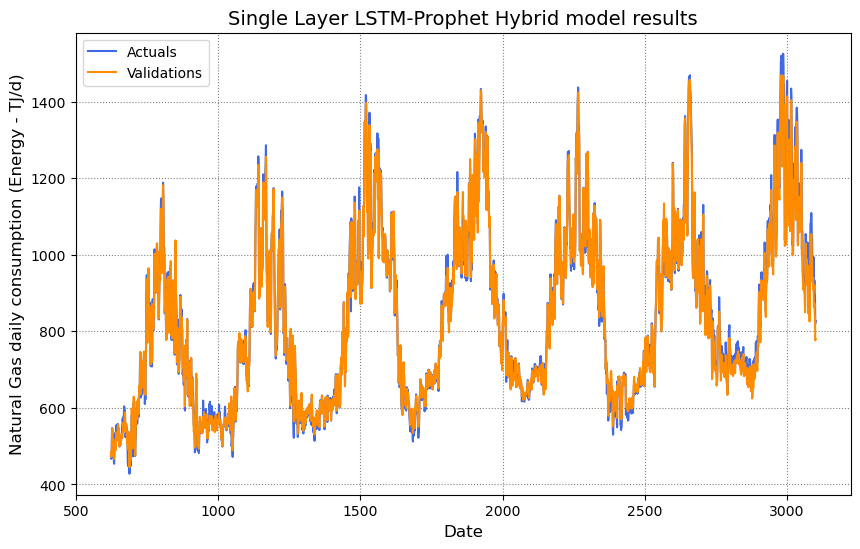


Average Prediction Metrics across Folds:
Mean Squared Error: 297.868
Mean Absolute Error: 11.966
Root Mean Squared Error: 16.649
Mean Absolute Percentage Error: 1.480%
Median Absolute Percentage Error: 1.111%
R-squared: 0.993


In [9]:
# Prepare your data
df = learning_data_df.copy()
df = df.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df.drop(columns=['y', 'ds']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df[['y']])

df_scaled = pd.concat([df[['ds', 'y']], pd.DataFrame(scaled_X, columns=df.columns.drop(['y', 'ds']))], axis=1)

# Define your additional regressors
additional_regressors = ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
                         'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
                         'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']

# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Add dropout with rate 0.2
    model.add(LSTM(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Add dropout with rate 0.2
    model.add(Dense(1))  # You can adjust the number of output units based on your problem
    model.compile(optimizer='adam', loss='mean_squared_error') 
    return model

# Define a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    # Calculate various performance metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    r_squared = r2_score(y_true, y_pred)
    
    return mse, mae, rmse, mape, mdape, r_squared
    
# Split your data into training and testing sets
tscv = TimeSeriesSplit(n_splits=4)

all_hybrid_metrics =[]
plt.figure(figsize=(10,6))

# Train your hybrid model with cross-validation
for train_index, test_index in tscv.split(df_scaled):
    train, test = df_scaled.iloc[train_index], df_scaled.iloc[test_index]

    prophet_model = Prophet()
    for regressor in additional_regressors:
        prophet_model.add_regressor(regressor)
    prophet_model.fit(train)
    prophet_predictions = prophet_model.predict(test)
    residuals = test['y'].values - prophet_predictions['yhat'].values

    # Save the Prophet model
    with open('../models/lstm_prophet_model.pkl', 'wb') as model_file:
        pickle.dump(prophet_model, model_file)

    # Create your LSTM model
    model = create_lstm_model(input_shape=(None, 1))
    
    # Train the LSTM model
    model.fit(residuals[:-1].reshape(-1, 1, 1), residuals[1:], epochs=50, batch_size=32, verbose=0)
    
    # Save the LSTM model
    model.save('../models/lstm_hybrid_model.h5')

    # Make predictions
    lstm_predictions = model.predict(residuals[:-1].reshape(-1, 1, 1)).flatten()

    hybrid_predictions = prophet_predictions['yhat'].values[:-1] + lstm_predictions

    # Calculate the performance metrics
    mse, mae, rmse, mape, mdape, r_squared = calculate_metrics(test['y'].values[:-1], hybrid_predictions)
    all_hybrid_metrics.append([mse, mae, rmse, mape, mdape, r_squared])

    # Print the performance metrics for this fold
    print(f"Fold Metrics - MSE: {mse:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.3f}%, MdAPE: {mdape:.3f}%, R-squared: {r_squared:.3f}")

    # Plot actuals vs. forecasts for this fold
    plt.plot(df.iloc[test_index].index[:-1], test['y'].values[:-1], color='royalblue', label='Actuals')
    plt.plot(df.iloc[test_index].index[:-1], hybrid_predictions, color='darkorange', label='Validations')

# Set the title for the plot
plt.title('Single Layer LSTM-Prophet Hybrid model results', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=12)

# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

# Calculate and print the average metrics across folds
avg_metrics = np.mean(all_hybrid_metrics, axis=0)   
print("\nAverage Prediction Metrics across Folds:")
print(f"Mean Squared Error: {avg_metrics[0]:.3f}")
print(f"Mean Absolute Error: {avg_metrics[1]:.3f}")
print(f"Root Mean Squared Error: {avg_metrics[2]:.3f}")
print(f"Mean Absolute Percentage Error: {avg_metrics[3]:.3f}%")
print(f"Median Absolute Percentage Error: {avg_metrics[4]:.3f}%")
print(f"R-squared: {avg_metrics[5]:.3f}")

In [20]:
print(avg_metrics)

[297.86826506  11.96562341  16.64933475   1.47952475   1.11051982
   0.99319956]


## Hyperparameter turning

Reloading Tuner from my_dir\lstm_tuning\tuner0.json


15:17:43 - cmdstanpy - INFO - Chain [1] start processing
15:17:44 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 1s 17ms/step
Fold Metrics - MSE: 173.071, MAE: 10.175, RMSE: 13.156, MAPE: 1.489%, MdAPE: 1.172%, R-squared: 0.995


15:18:28 - cmdstanpy - INFO - Chain [1] start processing
15:18:28 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 1s 18ms/step
Fold Metrics - MSE: 235.028, MAE: 10.002, RMSE: 15.331, MAPE: 1.361%, MdAPE: 0.824%, R-squared: 0.995


15:19:18 - cmdstanpy - INFO - Chain [1] start processing
15:19:19 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 1s 15ms/step
Fold Metrics - MSE: 114.738, MAE: 7.652, RMSE: 10.712, MAPE: 0.949%, MdAPE: 0.617%, R-squared: 0.998


15:20:04 - cmdstanpy - INFO - Chain [1] start processing
15:20:06 - cmdstanpy - INFO - Chain [1] done processing


20/20 [==============================] - 1s 20ms/step
Fold Metrics - MSE: 231.538, MAE: 10.829, RMSE: 15.216, MAPE: 1.119%, MdAPE: 0.745%, R-squared: 0.995


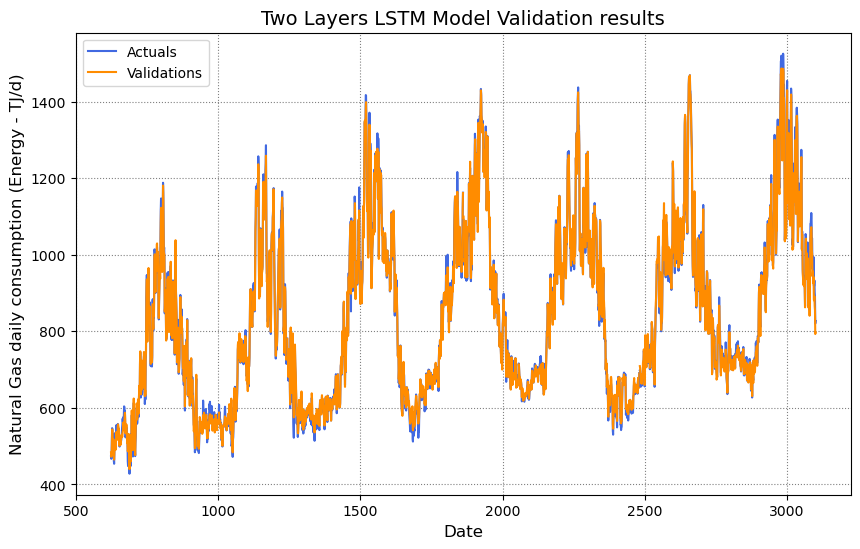


Average Validation Metrics across Folds:
Mean Squared Error: 188.594
Mean Absolute Error: 9.664
Root Mean Squared Error: 13.604
Mean Absolute Percentage Error: 1.230%
Median Absolute Percentage Error: 0.840%
R-squared: 0.996


In [18]:
# Prepare your data
df = learning_data_df.copy()
df = df.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df.drop(columns=['y', 'ds']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df[['y']])

df_scaled = pd.concat([df[['ds', 'y']], pd.DataFrame(scaled_X, columns=df.columns.drop(['y', 'ds']))], axis=1)

# Define your additional regressors
additional_regressors = ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
                         'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
                         'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']

# Define a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    # Calculate various performance metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    r_squared = r2_score(y_true, y_pred)
    
    return mse, mae, rmse, mape, mdape, r_squared

# Function to create LSTM model with tunable hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   activation='relu', return_sequences=True, input_shape=(None, 1),
                   kernel_regularizer=l2(0.01)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd']), 
              loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective=Objective('val_mean_absolute_error', direction='min'),  # set the objective to minimize mean absolute error
    max_trials=5,  # number of model configurations to test
    executions_per_trial=3,  # number of trials per configuration
    directory='my_dir',
    project_name='lstm_tuning')

# Split your data into training and testing sets
tscv = TimeSeriesSplit(n_splits=4)

opt_hybrid_metrics =[]
plt.figure(figsize=(10,6))

# Train your hybrid model with cross-validation
for train_index, test_index in tscv.split(df_scaled):
    train, test = df_scaled.iloc[train_index], df_scaled.iloc[test_index]

    prophet_model = Prophet()
    for regressor in additional_regressors:
        prophet_model.add_regressor(regressor)
    prophet_model.fit(train)
    prophet_predictions = prophet_model.predict(test)
    residuals = test['y'].values - prophet_predictions['yhat'].values

    # Save the Prophet model
    with open('../models/optimized_lstm_prophet_model.pkl', 'wb') as model_file:
        pickle.dump(prophet_model, model_file)
        
    # Perform hyperparameter search
    tuner.search(residuals[:-1].reshape(-1, 1, 1), residuals[1:], epochs=50, validation_split=0.2)
    
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # Build the model with the optimal hyperparameters
    model = tuner.hypermodel.build(best_hps)
    
    # Train the LSTM model
    model.fit(residuals[:-1].reshape(-1, 1, 1), residuals[1:], epochs=50, batch_size=32, verbose=0)

    # Save the LSTM model
    model.save('../models/optimized_lstm_hybrid_model.h5')

    # Make predictions
    lstm_predictions = model.predict(residuals[:-1].reshape(-1, 1, 1)).flatten()

    hybrid_predictions = prophet_predictions['yhat'].values[:-1] + lstm_predictions

    # Calculate the performance metrics
    mse, mae, rmse, mape, mdape, r_squared = calculate_metrics(test['y'].values[:-1], hybrid_predictions)
    opt_hybrid_metrics.append([mse, mae, rmse, mape, mdape, r_squared])

    # Print the performance metrics for this fold
    print(f"Fold Metrics - MSE: {mse:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.3f}%, MdAPE: {mdape:.3f}%, R-squared: {r_squared:.3f}")

    # Plot actuals vs. forecasts for this fold
    plt.plot(df.iloc[test_index].index[:-1], test['y'].values[:-1], color='royalblue', label='Actuals')
    plt.plot(df.iloc[test_index].index[:-1], hybrid_predictions, color='darkorange', label='Validations')

# Set the title for the plot
plt.title('Two Layers LSTM Model Validation results', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=12)

# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

# Calculate and print the average metrics across folds
avg_optimized_metrics = np.mean(opt_hybrid_metrics, axis=0)   
print("\nAverage Validation Metrics across Folds:")
print(f"Mean Squared Error: {avg_optimized_metrics[0]:.3f}")
print(f"Mean Absolute Error: {avg_optimized_metrics[1]:.3f}")
print(f"Root Mean Squared Error: {avg_optimized_metrics[2]:.3f}")
print(f"Mean Absolute Percentage Error: {avg_optimized_metrics[3]:.3f}%")
print(f"Median Absolute Percentage Error: {avg_optimized_metrics[4]:.3f}%")
print(f"R-squared: {avg_optimized_metrics[5]:.3f}")

In [22]:
# Access individual metrics from the optimized hybrid model validation (LSTM-Prophet hybrid model)
mse_lstm_ph = avg_metrics[0]
mae_lstm_ph = avg_metrics[1]
rmse_lstm_ph = avg_metrics[2]
mape_lstm_ph = avg_metrics[3]
mdape_lstm_ph = avg_metrics[4]
r2_lstm_ph = avg_metrics[5]

# Access individual metrics from the optimized hybrid model validation (LSTM-Prophet hybrid model)
mse_lstm_ph2 = avg_optimized_metrics[0]
mae_lstm_ph2 = avg_optimized_metrics[1]
rmse_lstm_ph2 =avg_optimized_metrics[2]
mape_lstm_ph2 = avg_optimized_metrics[3]
mdape_lstm_ph2 = avg_optimized_metrics[4]
r2_lstm_ph2 = avg_optimized_metrics[5]

metrics_bm = [mse_bm, rmse_bm, mape_bm, mae_bm, mdape_bm, r2_bm]
metrics_lstm_ph = [mse_lstm_ph, rmse_lstm_ph, mape_lstm_ph, mae_lstm_ph, mdape_lstm_ph, r2_lstm_ph]
metrics_optimized_lstm_ph = [mse_lstm_ph2, rmse_lstm_ph2, mape_lstm_ph2, mae_lstm_ph2, mdape_lstm_ph2, r2_lstm_ph2]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_lstm_prophet_metrics = pd.DataFrame({'Baseline Model': metrics_bm, 'LSTM-Prophet hybrid model': metrics_lstm_ph, 'Optimized LSTM-Prophet hybrid model': metrics_optimized_lstm_ph}, index=labels)

# Transpose the DataFrame
df_lstm_prophet_metrics = df_lstm_prophet_metrics.transpose()                                       

df_lstm_prophet_metrics  = df_lstm_prophet_metrics.applymap(lambda x: f'{x: .3f}')
df_lstm_prophet_metrics.head(10)

,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
Baseline Model,6656.063,81.585,7.334,70.175,7.052,0.854
LSTM-Prophet hybrid model,297.868,16.649,1.480,11.966,1.111,0.993
Optimized LSTM-Prophet hybrid model,188.594,13.604,1.230,9.664,0.840,0.996


## LSTM-Prophet Model Testing Performance

**1. Hybrid model with Cross-validation**

18/18 [==============================] - 1s 16ms/step

Prediction Hybrid Performance Metrics for the Testing Dataset:
Test Mean Squared Error: 5008.470
Test Mean Absolute Error: 64.008
Test Root Mean Squared Error: 70.771
Test Mean Absolute Percentage Error: 7.258%
Test Median Absolute Percentage Error: 6.299%
Test R-squared: 0.881

Prediction Optimized Hybrid Performance Metrics for the Testing Dataset:
Test Mean Squared Error: 2638.454
Test Mean Absolute Error: 44.811
Test Root Mean Squared Error: 51.366
Test Mean Absolute Percentage Error: 5.074%
Test Median Absolute Percentage Error: 4.367%
Test R-squared: 0.937


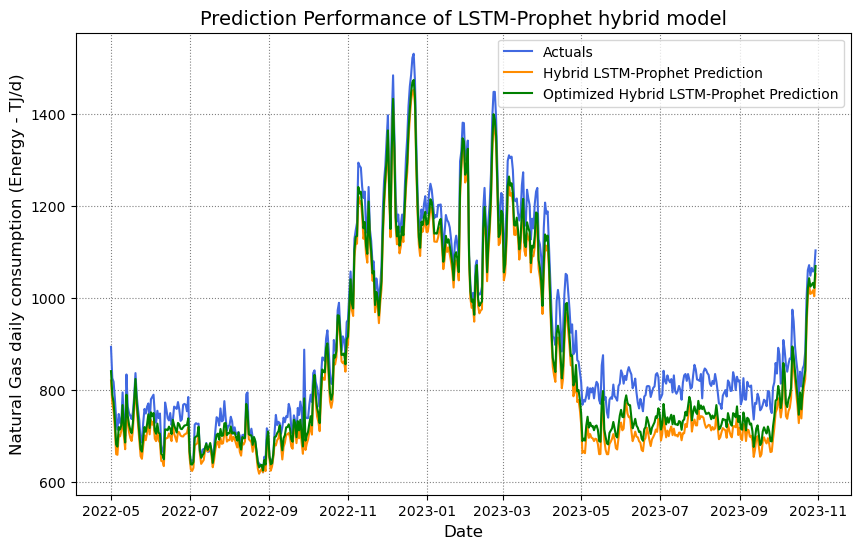

In [23]:
# Load the saved Prophet model
with open('../models/lstm_prophet_model.pkl', 'rb') as model_file:
    loaded_prophet_model = pickle.load(model_file)

# Load the saved Optimized Prophet model
with open('../models/optimized_lstm_prophet_model.pkl', 'rb') as model_file:
    loaded_optimized_prophet_model = pickle.load(model_file)

# Load the saved LSTM model
loaded_lstm_model = load_model('../models/lstm_hybrid_model.h5')

# Load the saved optimized LSTM model
loaded_optimized_lstm_model = load_model('../models/optimized_lstm_hybrid_model.h5')

# Now you can use the loaded models to make predictions on new data
# Prepare your new data for prediction (similar preprocessing as before)
testing_df = testing_data_df.copy()  # Load or prepare your new data here
testing_df = testing_df.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(testing_df.drop(columns=['y', 'ds']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(testing_df[['y']])

testing_df_subset = testing_df[['ds', 'y']].reset_index(drop=True)
scaled_X_df = pd.DataFrame(scaled_X, columns=testing_df.columns.drop(['y', 'ds'])).reset_index(drop=True)
testing_df_scaled = pd.concat([testing_df_subset, scaled_X_df], axis=1)   

# Define your additional regressors
additional_regressors = ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
                         'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
                         'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']

# For Prophet model prediction
prophet_test_predictions = loaded_prophet_model.predict(testing_df_scaled)
prophet_test2_predictions = loaded_optimized_prophet_model.predict(testing_df_scaled)

# For LSTM model prediction (assuming 'residuals' are computed similar to the previous code)
test_residuals = testing_df_scaled['y'].values - prophet_test_predictions['yhat'].values    # Compute residuals for new data
test2_residuals = testing_df_scaled['y'].values - prophet_test2_predictions['yhat'].values    # Compute residuals for new data

lstm_test_predictions = loaded_lstm_model.predict(test_residuals[:-1].reshape(-1, 1, 1)).flatten()
lstm_test2_predictions = loaded_optimized_lstm_model.predict(test2_residuals[:-1].reshape(-1, 1, 1)).flatten()

# Combine predictions (hybrid) or use them separately based on your requirements
hybrid_test_predictions = prophet_test_predictions['yhat'].values[:-1] + lstm_test_predictions
hybrid_test2_predictions = prophet_test2_predictions['yhat'].values[:-1] + lstm_test2_predictions

# Create a dataframe that contains actuals and predictions
hybrid_results_df = pd.DataFrame()
hybrid_results_df['ds'] = testing_df_scaled['ds'].values[:-1]
hybrid_results_df['y'] = testing_df_scaled['y'].values[:-1]
hybrid_results_df['Predicted_y'] = hybrid_test_predictions
hybrid_results_df['Optimized_Predicted_y'] = hybrid_test2_predictions

# Calculate performance metrics for the test set
test_mse, test_mae, test_rmse, test_mape, test_mdape, test_r_squared = calculate_metrics(hybrid_results_df['y'], hybrid_results_df['Predicted_y'])
test2_mse, test2_mae, test2_rmse, test2_mape, test2_mdape, test2_r_squared = calculate_metrics(hybrid_results_df['y'], hybrid_results_df['Optimized_Predicted_y'])

# Print hybrid prediction performance metrics
print("\nPrediction Hybrid Performance Metrics for the Testing Dataset:")
print(f'Test Mean Squared Error: {test_mse:.3f}')
print(f'Test Mean Absolute Error: {test_mae:.3f}')
print(f'Test Root Mean Squared Error: {test_rmse:.3f}')
print(f'Test Mean Absolute Percentage Error: {test_mape:.3f}%')
print(f'Test Median Absolute Percentage Error: {test_mdape:.3f}%')
print(f'Test R-squared: {test_r_squared:.3f}')

# Print optimized hybrid prediction performance metrics
print("\nPrediction Optimized Hybrid Performance Metrics for the Testing Dataset:")
print(f'Test Mean Squared Error: {test2_mse:.3f}')
print(f'Test Mean Absolute Error: {test2_mae:.3f}')
print(f'Test Root Mean Squared Error: {test2_rmse:.3f}')
print(f'Test Mean Absolute Percentage Error: {test2_mape:.3f}%')
print(f'Test Median Absolute Percentage Error: {test2_mdape:.3f}%')
print(f'Test R-squared: {test2_r_squared:.3f}')

# Convert date to Datatime
hybrid_results_df['ds'] = pd.to_datetime(hybrid_results_df['ds'])

# Plot actuals vs. forecasts for this fold
plt.figure(figsize=(10, 6))
plt.plot(hybrid_results_df['ds'], hybrid_results_df['y'], color='royalblue', label='Actuals')
plt.plot(hybrid_results_df['ds'], hybrid_results_df['Predicted_y'], color='darkorange', label='Hybrid LSTM-Prophet Prediction')
plt.plot(hybrid_results_df['ds'], hybrid_results_df['Optimized_Predicted_y'], color='green', label='Optimized Hybrid LSTM-Prophet Prediction')
plt.title('Prediction Performance of LSTM-Prophet hybrid model', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=12)
plt.legend()
plt.grid(linestyle=":", color='grey')
plt.show()

In [24]:
# Save the prediction result dataframe
hybrid_results_df.to_csv('../data/hybrid_prediction.csv', index=False)
hybrid_results_df.head()

,ds,y,Predicted_y,Optimized_Predicted_y
0,2022-05-01,894,820.883303,841.266054
1,2022-05-02,826,772.038173,789.767253
2,2022-05-03,818,754.096731,773.140112
3,2022-05-04,782,715.880441,735.235040
4,2022-05-05,737,660.534089,681.433595


In [25]:
# Define the metrics for the predicted model
lstm_prophet_prediction_metrics = [test2_mse, test2_mae, test2_rmse, test2_mape, test2_mdape, test2_r_squared]

# Define the labels for the metrics
labels = ['MSE', 'MAE', 'RMSE', 'MAPE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_lstm_prophet__pred = pd.DataFrame({'Optimized LSTM-Prophet Model Prediction': lstm_prophet_prediction_metrics}, index=labels)

# Transpose the DataFrame
df_lstm_prophet__pred = df_lstm_prophet__pred.transpose()

# Save the DataFrame to a CSV file
df_lstm_prophet__pred.to_csv('../data/hybrid_predictions_metrics.csv', index=False)
df_lstm_prophet__pred.head(10)

,MSE,MAE,RMSE,MAPE,MDAPE,R-squared
Optimized LSTM-Prophet Model Prediction,2638.454094,44.810526,51.365885,5.074441,4.367038,0.937336
